In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load Dataset
data_dir = './data/vegetables'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Number of classes in dataset: {len(train_dataset.classes)}")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in val dataset: {len(val_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of classes in dataset: 15
Number of samples in train dataset: 15000
Number of samples in val dataset: 3000
Number of samples in test dataset: 3000


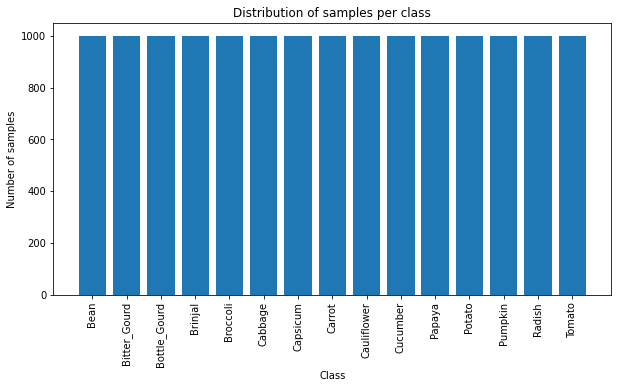

In [24]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(train_dataset.targets)
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
sorted_class_counts = [class_counts[i] for i in range(num_classes)]

plt.figure(figsize=(10, 5), facecolor='white')
plt.bar(range(num_classes), sorted_class_counts, tick_label=class_names)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Distribution of samples per class')
plt.xticks(rotation=90)
plt.show()

In [25]:
class VegetableClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VegetableClassifier, self).__init__()
        self.base_model = models.squeezenet1_0(pretrained=True)
        self.base_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.base_model.num_classes = num_classes

    def forward(self, x):
        return self.base_model(x)


num_classes = len(train_dataset.classes)
model = VegetableClassifier(num_classes).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

print(f"Best Validation Accuracy: {best_acc:.4f}")


Epoch 1/10
Train Loss: 1.3379, Train Acc: 0.5515
Validation Loss: 0.7267, Validation Acc: 0.7833
Epoch 2/10
Train Loss: 0.4901, Train Acc: 0.8514
Validation Loss: 0.2500, Validation Acc: 0.9257
Epoch 3/10
Train Loss: 0.2897, Train Acc: 0.9138
Validation Loss: 0.1313, Validation Acc: 0.9620
Epoch 4/10
Train Loss: 0.2611, Train Acc: 0.9231
Validation Loss: 0.2846, Validation Acc: 0.9347
Epoch 5/10
Train Loss: 0.1672, Train Acc: 0.9507
Validation Loss: 0.2819, Validation Acc: 0.9160
Epoch 6/10
Train Loss: 0.1319, Train Acc: 0.9615
Validation Loss: 0.0671, Validation Acc: 0.9807
Epoch 7/10
Train Loss: 0.1636, Train Acc: 0.9534
Validation Loss: 0.0803, Validation Acc: 0.9740
Epoch 8/10
Train Loss: 0.1173, Train Acc: 0.9679
Validation Loss: 0.2378, Validation Acc: 0.9203
Epoch 9/10
Train Loss: 0.1165, Train Acc: 0.9673
Validation Loss: 0.0601, Validation Acc: 0.9817
Epoch 10/10
Train Loss: 0.1057, Train Acc: 0.9702
Validation Loss: 0.1438, Validation Acc: 0.9533
Best Validation Accuracy: 0.9

Test Loss: 0.0616, Test Accuracy: 0.9857


<Figure size 1872x1872 with 0 Axes>

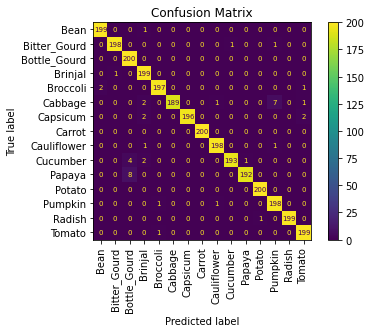

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_and_plot_stats(model, loader, device, class_names):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total

    print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names,)
    plt.figure(figsize=(26, 26))  
    disp.plot(xticks_rotation='vertical')
    for texts in disp.text_.ravel():
        texts.set_fontsize(7)  
    plt.title('Confusion Matrix')
    plt.gcf().set_facecolor('white')
    plt.show()

class_names = train_dataset.classes
model.load_state_dict(torch.load('best_model.pth'))
test_and_plot_stats(model, test_loader, device, class_names)